# Детекция аномалий

In [21]:
!pip install lightning
!pip install torchsummary


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: lightning-lite 1.8.0 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of lightning-lite or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: lightning-lite 1.8.0 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this beh

In [41]:
from PIL import Image
from sklearn.metrics import confusion_matrix

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import tqdm
import os
from torchsummary import summary

from matplotlib.pyplot import imshow

In [5]:
from lightning import seed_everything
seed_everything(seed=7, workers=True)

Seed set to 7


7

In [13]:
folder_path = "./data/dataset/train"


### Пример случайного изображения

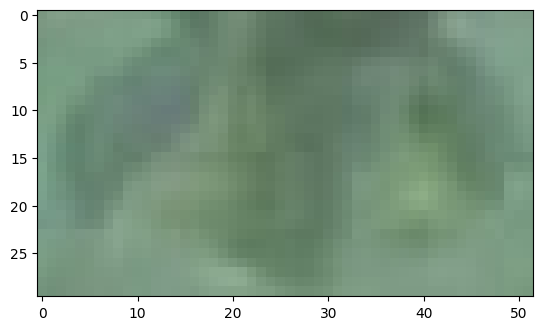

In [11]:
pil_im = Image.open('data/dataset/test/imgs/fefb9211-127e-4832-b21b-36cbbe64aeb0.jpg', 'r')
imshow(np.asarray(pil_im))

In [12]:
def create_datasets_and_loaders(root_path, train_transform, test_transform, train_split=0.9, batch_size=1024):
    # Dataset creation with augmentation
    dataset = datasets.ImageFolder(root=root_path, transform=train_transform)
    
    # Splitting the dataset
    train_size = int(train_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])

    # Adjusting validation dataset transform
    validation_dataset.dataset.transform = test_transform

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader

In [ ]:
target_size = 32

## Аугментация

In [56]:
target_size = 48
preprocess_augm = transforms.Compose([
    transforms.Resize((target_size, target_size)),
    transforms.RandomRotation(15),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomResizedCrop(target_size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
preprocess = transforms.Compose([
    transforms.Resize((target_size, target_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])

# Create datasets and loaders
train_loader, validation_loader = create_datasets_and_loaders(
    'data/dataset/train_neproliv', 
    preprocess_augm, 
    preprocess, 
    train_split=0.9, 
    batch_size=1024
)

## Модель

In [126]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, in_channels):
        super(Attention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels//8, in_channels, kernel_size=1)
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        x = x * x
        x = x * self.pool(x)
        return x

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=2)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1)
        self.attention = Attention(128)
        self.upsample = nn.Upsample(scale_factor=2, mode='bicubic')
        self.conv8 = nn.Conv2d(128, 64, kernel_size=3, padding=1, stride=1)
        self.conv9 = nn.Conv2d(64, 32, kernel_size=3, padding=1, stride=1)
        self.conv10 = nn.Conv2d(32, 3, kernel_size=3, padding=1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Define the forward pass
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.attention(x) * x
        x = self.upsample(x)
        x = self.conv8(x)
        x = self.upsample(x)
        x = self.conv9(x)
        x = self.upsample(x)
        x = self.sigmoid(self.conv10(x))
        # print(x.shape)
        return x
    
device = 'cuda'
model = Model().to(device=device)
summary(model, (3, target_size,target_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             896
              ReLU-2           [-1, 32, 48, 48]               0
            Conv2d-3           [-1, 32, 24, 24]           9,248
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          18,496
              ReLU-6           [-1, 64, 24, 24]               0
            Conv2d-7           [-1, 64, 12, 12]          36,928
              ReLU-8           [-1, 64, 12, 12]               0
            Conv2d-9          [-1, 128, 12, 12]          73,856
           Conv2d-10            [-1, 128, 6, 6]         147,584
           Conv2d-11            [-1, 128, 6, 6]         147,584
           Conv2d-12             [-1, 16, 6, 6]           2,064
           Conv2d-13            [-1, 128, 6, 6]           2,176
AdaptiveAvgPool2d-14            [-1, 12

Обучение

In [165]:
learning_rate = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()
#learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

Epoch 1/100, Train Loss: 0.003358, Validation Loss: 0.001635
Epoch 2/100, Train Loss: 0.001309, Validation Loss: 0.000965
Epoch 3/100, Train Loss: 0.000794, Validation Loss: 0.000675
Epoch 4/100, Train Loss: 0.000623, Validation Loss: 0.000562
Epoch 5/100, Train Loss: 0.000539, Validation Loss: 0.000501
Epoch 6/100, Train Loss: 0.000506, Validation Loss: 0.000462
Epoch 7/100, Train Loss: 0.000553, Validation Loss: 0.000465
Epoch 8/100, Train Loss: 0.000482, Validation Loss: 0.000451
Epoch 9/100, Train Loss: 0.000440, Validation Loss: 0.000427
Epoch 10/100, Train Loss: 0.000412, Validation Loss: 0.000400
Epoch 11/100, Train Loss: 0.000392, Validation Loss: 0.000381
Epoch 12/100, Train Loss: 0.000379, Validation Loss: 0.000371
Epoch 13/100, Train Loss: 0.000367, Validation Loss: 0.000360
Epoch 14/100, Train Loss: 0.000356, Validation Loss: 0.000350
Epoch 15/100, Train Loss: 0.000347, Validation Loss: 0.000341
Epoch 16/100, Train Loss: 0.000343, Validation Loss: 0.000353
Epoch 17/100, Tra

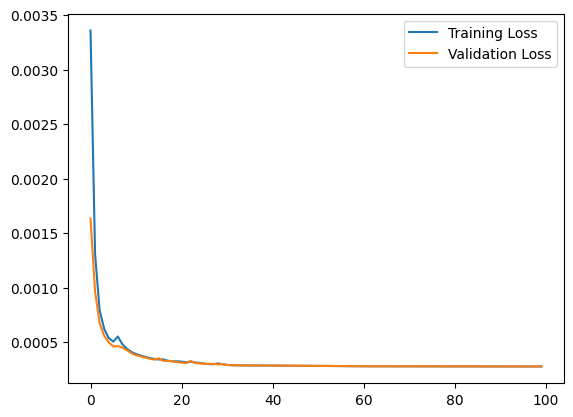

In [166]:
num_epochs = 100
train_losses = []
val_losses = []
early_stopping_patience = 10
min_val_loss = np.inf
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)
        train_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
    
    # Validation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, _ in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item()
    
    validation_loss /= len(validation_loader)
    train_loss /= len(train_loader)
    
    train_losses.append(train_loss)
    val_losses.append(validation_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {validation_loss:.6f}")

    # Early stopping check
    if validation_loss < min_val_loss:
        min_val_loss = validation_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break


torch.save(model.state_dict(), 'model.pth')
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

## Считаем лося

In [170]:
def compute_loss(model, dataset, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for images, _ in DataLoader(dataset, batch_size=1, shuffle=False):
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            losses.append(loss.item())
    return np.array(losses)

def loss_df(losses, dataset):
    
    records = [{'img': path[0].split('/')[-1], 'loss': loss} for (path, loss) in zip(dataset.imgs, losses)]
    return pd.DataFrame(records)

def calculate_tpr_tnr(predictions_df, threshold):
    predictions_df['predictions'] = (predictions_df['loss'] > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(predictions_df['class'], predictions_df['predictions']).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    return tpr, tnr

In [171]:
# Compute losses for the 'proliv' dataset
proliv_dataset = ImageFolder(root='./data/dataset/proliv_test', transform=preprocess)

# Compute losses for the test dataset
test_dataset = ImageFolder(root='./data/dataset/test/', transform=preprocess)

In [186]:
losses_proliv = compute_loss(model, proliv_dataset, criterion, device)

losses_test = compute_loss(model, test_dataset, criterion, device)

merged = pd.merge(loss_df(losses_test, test_dataset), pd.read_csv('./data/dataset/test/test_annotation.txt', sep=' ', names=['img', 'class']), how='left', on='img')

# Calculate TPR and TNR for different trashholds
thresholds_for_classification = [np.min(losses_proliv), np.mean(losses_proliv), np.max(losses_proliv)]

for threshold in thresholds_for_classification:
    
    tpr, tnr = calculate_tpr_tnr(merged, threshold)
    print(f"TPR: {tpr}, TNR: {tnr} with threshold = {threshold}")

TPR: 0.9124806201550387, TNR: 0.8848567530695771 with threshold = 0.0006198423798196018
TPR: 0.6566666666666666, TNR: 0.9961800818553889 with threshold = 0.0017471729045243959
TPR: 0.03651162790697674, TNR: 0.9997271487039563 with threshold = 0.003713481593877077


## Подбор Трешхолда (очень по-дурацки, но работает)

In [181]:
thresholds = np.arange(0.0, 0.004, 0.000001)

TPR: 0.9224806201550387, TNR: 0.9086766712141883 with threshold = 0.000634


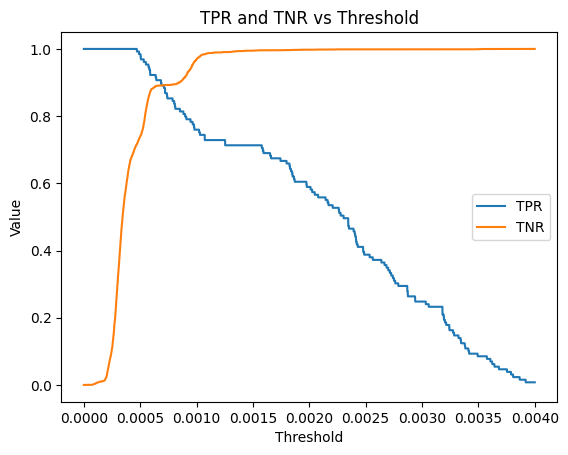

In [184]:
import matplotlib.pyplot as plt

# список трешхолдов

optimal_threshold = 0
optimal_tpr = 0
optimal_tnr = 0
# списки значений TPR и TNR для каждого трешхолда
tprs = []
tnrs = []
min_diff = 0
# вычисление TPR и TNR для каждого трешхолда
for threshold in thresholds:
    tpr, tnr = calculate_tpr_tnr(merged, threshold)
    if abs(tpr+tnr) > min_diff:
        min_diff = abs(tpr+tnr)
        optimal_threshold = threshold
        optimal_tpr = tpr
        optimal_tnr = tnr
    tprs.append(tpr)
    tnrs.append(tnr)
    # print(f"TPR: {tpr}, TNR: {tnr} with threshold = {threshold}")

# построение графиков
print(f"TPR: {optimal_tpr}, TNR: {optimal_tnr} with threshold = {optimal_threshold}")
plt.plot(thresholds, tprs, label='TPR')
plt.plot(thresholds, tnrs, label='TNR')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.title('TPR and TNR vs Threshold')
plt.legend()
plt.show()